In [19]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from src.pv_curve import PVCurveAnalysis

def setup_system():
    """Setup the 4-bus system from the example"""
    # Define system
    barras = [1, 2, 3, 4]
    barras_tipo = {1: 0, 2: 2, 3: 2, 4: 2}  # 0: slack, 1: PV, 2: PQ
    
    # Complex powers (S = P + jQ) in pu
    potencias = {
        1: 0.0 - 0.7j,  # Slack bus
        2: -1.28 - 1.28j,  # Negative for load
        3: -0.32 - 0.16j,  # Negative for load
        4: -1.6 - 0.80j    # Negative for load
    }
    
    # Initial voltages
    v_inicial = {
        1: 1.03 + 0.0j,  # Reference voltage at slack bus
        2: 1.0 + 0.0j,
        3: 1.0 + 0.0j,
        4: 1.0 + 0.0j
    }
    
    # Lines (connections between buses)
    linhas = [(1, 2), (2, 3), (2, 4)]
    
    # Line impedances
    z12 = 0.0236 + 0.0233j
    z23 = 0.045 + 0.030j
    z24 = 0.0051 + 0.0005j
    
    # Series admittances of lines
    y12 = 1 / z12
    y23 = 1 / z23
    y24 = 1 / z24
    
    # Total shunt admittance per line (j0.01 pu)
    y_shunt = 0.01j
    
    # Build admittance matrix Y_bus
    Y_bus = np.zeros((4, 4), dtype=complex)
    
    # Diagonal elements (sum of admittances connected to bus)
    Y_bus[0, 0] = y12 + y_shunt/2  # Bus 1
    Y_bus[1, 1] = y12 + y23 + y24 + y_shunt/2 + y_shunt/2 + y_shunt/2  # Bus 2
    Y_bus[2, 2] = y23 + y_shunt/2  # Bus 3
    Y_bus[3, 3] = y24 + y_shunt/2  # Bus 4
    
    # Off-diagonal elements (negative of admittance between buses)
    Y_bus[0, 1] = Y_bus[1, 0] = -y12
    Y_bus[1, 2] = Y_bus[2, 1] = -y23
    Y_bus[1, 3] = Y_bus[3, 1] = -y24
    
    return {
        'barras': barras,
        'barras_tipo': barras_tipo,
        'potencias': potencias,
        'v_inicial': v_inicial,
        'linhas': linhas,
        'Y_bus': Y_bus
    }


def plot_pv_curves(results_dict, scenario_name):
    """Plot P-V curves for a specific load scenario"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract results
    load_multipliers = results_dict['load_multipliers']
    voltages = results_dict['voltages']
    
    # Find last converged point
    last_converged_idx = results_dict['converged'].index(False) - 1 if False in results_dict['converged'] else -1
    max_load = load_multipliers[last_converged_idx]
    
    # Plot P-V curves for all buses except slack
    for bus, v_values in sorted(voltages.items()):
        if bus != 1:  # Skip slack bus
            # Remove any None values (non-converged points)
            valid_points = [(lm, v) for lm, v in zip(load_multipliers, v_values) if v is not None]
            if valid_points:
                lm_valid, v_valid = zip(*valid_points)
                ax.plot(lm_valid, v_valid, 'o-', linewidth=2, label=f'Bus {bus}')
    
    # Add vertical line at maximum load
    ax.axvline(x=max_load, linestyle='--', color='r', 
               label=f'Max Load: {max_load:.2f}x')
    
    # Customize plot
    ax.set_title(f'P-V Curves - {scenario_name}', fontsize=14)
    ax.set_xlabel('Load Multiplier', fontsize=12)
    ax.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add annotations for maximum load
    y_pos = ax.get_ylim()[0] + 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.annotate(f'Maximum Loading: {max_load:.2f}x', 
                xy=(max_load, y_pos),
                xytext=(max_load - 0.1, y_pos),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)
    
    plt.tight_layout()
    return fig


def run_pv_curve_analysis():
    """Run PV curve analysis for all load scenarios"""
    # Setup the base system
    system = setup_system()
    
    # Define load scenarios
    load_scenarios = [
        {"name": "100% Constant Power", "models": {
            1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            4: {'P': 1.0, 'I': 0.0, 'Z': 0.0}
        }},
        {"name": "100% Constant Current", "models": {
            1: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            2: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            3: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            4: {'P': 0.0, 'I': 1.0, 'Z': 0.0}
        }},
        {"name": "100% Constant Impedance", "models": {
            1: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            2: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            3: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            4: {'P': 0.0, 'I': 0.0, 'Z': 1.0}
        }},
        {"name": "Mixed Model (ZIP)", "models": {
            1: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            2: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            3: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            4: {'P': 0.4, 'I': 0.3, 'Z': 0.3}
        }}
    ]
    
    # Create PV curve analyzer
    analyzer = PVCurveAnalysis(system)
    
    # Results to store all scenarios
    all_results = {}
    
    # Run analysis for each scenario
    for scenario in load_scenarios:
        print(f"\n=== Running PV curve analysis for {scenario['name']} ===")
        
        # Run analysis with 1% load increment
        results = analyzer.run_pv_analysis(
            load_models=scenario['models'],
            max_iterations=100,  # Max iterations per power flow solution
            step_size=0.01,      # 1% load increase per step
            tol=1e-3             # Convergence tolerance
        )
        
        # Store results
        all_results[scenario['name']] = results
        
        # Plot PV curves for this scenario
        fig = plot_pv_curves(results, scenario['name'])
        plt.show()
        #plt.savefig(f"pv_curve_{scenario['name'].replace(' ', '_').lower()}.png")
        plt.close(fig)
    
    # Create summary comparison
    create_summary_comparison(all_results)
    
    return all_results


def create_summary_comparison(all_results):
    """Create summary comparison of maximum loading points for all scenarios"""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Extract maximum loading points for each scenario
    scenario_names = []
    max_loads = []
    bus_voltages = {2: [], 3: [], 4: []}
    
    for name, results in all_results.items():
        # Find last converged point
        last_idx = results['converged'].index(False) - 1 if False in results['converged'] else -1
        max_load = results['load_multipliers'][last_idx]
        
        scenario_names.append(name)
        max_loads.append(max_load)
        
        # Get bus voltages at maximum loading
        for bus in [2, 3, 4]:
            bus_voltages[bus].append(results['voltages'][bus][last_idx])
    
    # Plot maximum loading comparison
    x = np.arange(len(scenario_names))
    ax1.bar(x, max_loads, width=0.6)
    ax1.set_title('Maximum Loading Comparison', fontsize=14)
    ax1.set_xlabel('Load Model', fontsize=12)
    ax1.set_ylabel('Maximum Load Multiplier', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(max_loads):
        ax1.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
    
    # Plot bus voltages at maximum loading
    bar_width = 0.25
    x = np.arange(len(scenario_names))
    
    for i, (bus, voltages) in enumerate(bus_voltages.items()):
        offset = (i - 1) * bar_width
        ax2.bar(x + offset, voltages, width=bar_width, label=f'Bus {bus}')
    
    ax2.set_title('Bus Voltages at Maximum Loading', fontsize=14)
    ax2.set_xlabel('Load Model', fontsize=12)
    ax2.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    #plt.savefig("pv_curve_summary_comparison.png")
    plt.close(fig)


=== Running PV curve analysis for 100% Constant Power ===
Completed load multiplier: 1.20, voltages: V2=0.8496, V3=0.8220, V4=0.8375
Completed load multiplier: 1.40, voltages: V2=0.8076, V3=0.7733, V4=0.7926
Completed load multiplier: 1.60, voltages: V2=0.7572, V3=0.7146, V4=0.7387
Completed load multiplier: 1.80, voltages: V2=0.6911, V3=0.6373, V4=0.6682
Load multiplier 1.9800 failed to converge


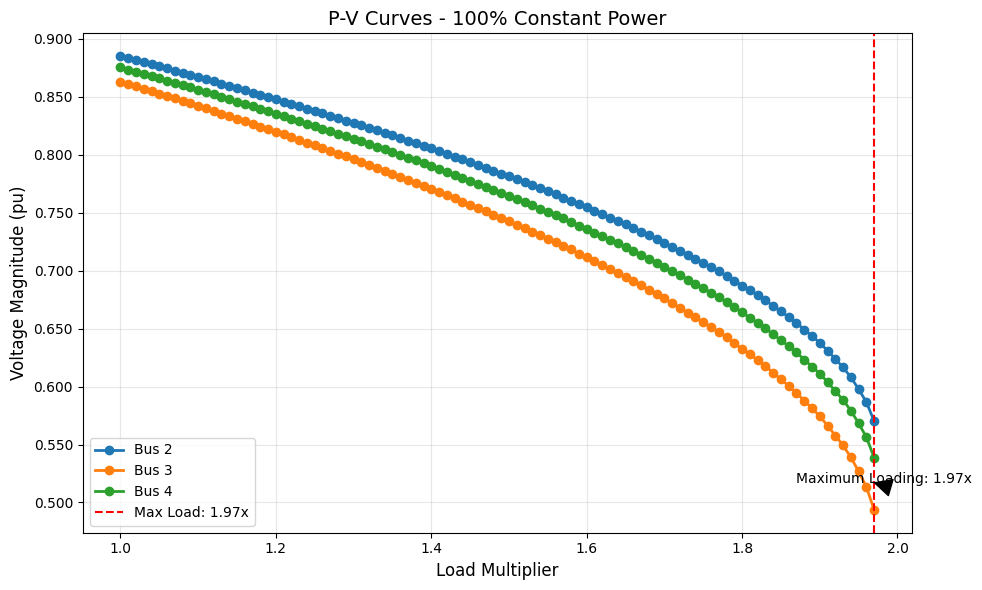


=== Running PV curve analysis for 100% Constant Current ===
Completed load multiplier: 1.20, voltages: V2=0.8783, V3=0.8556, V4=0.8681
Completed load multiplier: 1.40, voltages: V2=0.8526, V3=0.8260, V4=0.8407
Completed load multiplier: 1.60, voltages: V2=0.8269, V3=0.7965, V4=0.8133
Completed load multiplier: 1.80, voltages: V2=0.8013, V3=0.7670, V4=0.7860
Completed load multiplier: 2.00, voltages: V2=0.7756, V3=0.7375, V4=0.7586
Completed load multiplier: 2.20, voltages: V2=0.7499, V3=0.7079, V4=0.7311
Completed load multiplier: 2.40, voltages: V2=0.7242, V3=0.6784, V4=0.7037
Completed load multiplier: 2.60, voltages: V2=0.6985, V3=0.6488, V4=0.6762
Completed load multiplier: 2.80, voltages: V2=0.6728, V3=0.6193, V4=0.6489
Completed load multiplier: 3.00, voltages: V2=0.6471, V3=0.5897, V4=0.6214
Completed load multiplier: 3.20, voltages: V2=0.6212, V3=0.5600, V4=0.5939
Completed load multiplier: 3.40, voltages: V2=0.5955, V3=0.5304, V4=0.5664
Completed load multiplier: 3.60, voltag

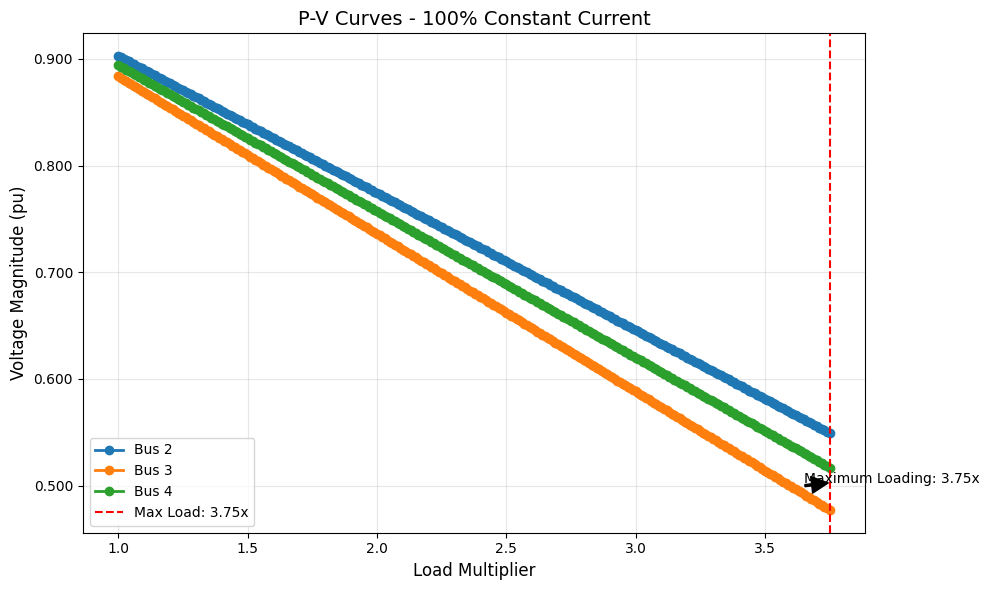


=== Running PV curve analysis for 100% Constant Impedance ===
Completed load multiplier: 1.20, voltages: V2=0.8952, V3=0.8753, V4=0.8862
Completed load multiplier: 1.40, voltages: V2=0.8759, V3=0.8532, V4=0.8656
Completed load multiplier: 1.60, voltages: V2=0.8575, V3=0.8322, V4=0.8460
Completed load multiplier: 1.80, voltages: V2=0.8398, V3=0.8120, V4=0.8272
Completed load multiplier: 2.00, voltages: V2=0.8231, V3=0.7929, V4=0.8093
Completed load multiplier: 2.20, voltages: V2=0.8070, V3=0.7745, V4=0.7921
Completed load multiplier: 2.40, voltages: V2=0.7914, V3=0.7567, V4=0.7755
Completed load multiplier: 2.60, voltages: V2=0.7764, V3=0.7397, V4=0.7596
Completed load multiplier: 2.80, voltages: V2=0.7622, V3=0.7235, V4=0.7444
Completed load multiplier: 3.00, voltages: V2=0.7484, V3=0.7079, V4=0.7297
Completed load multiplier: 3.20, voltages: V2=0.7351, V3=0.6928, V4=0.7155
Completed load multiplier: 3.40, voltages: V2=0.7223, V3=0.6783, V4=0.7019
Completed load multiplier: 3.60, volt

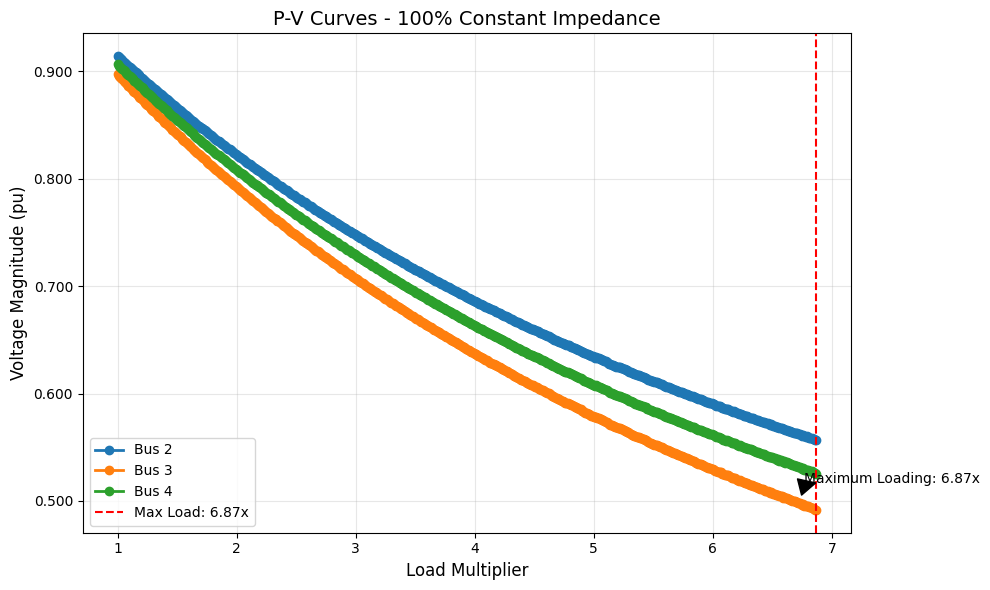


=== Running PV curve analysis for Mixed Model (ZIP) ===
Completed load multiplier: 1.20, voltages: V2=0.8751, V3=0.8518, V4=0.8646
Completed load multiplier: 1.40, voltages: V2=0.8476, V3=0.8201, V4=0.8353
Completed load multiplier: 1.60, voltages: V2=0.8194, V3=0.7877, V4=0.8053
Completed load multiplier: 1.80, voltages: V2=0.7905, V3=0.7543, V4=0.7744
Completed load multiplier: 2.00, voltages: V2=0.7606, V3=0.7197, V4=0.7424
Completed load multiplier: 2.20, voltages: V2=0.7292, V3=0.6834, V4=0.7089
Completed load multiplier: 2.40, voltages: V2=0.6960, V3=0.6450, V4=0.6736
Completed load multiplier: 2.60, voltages: V2=0.6603, V3=0.6035, V4=0.6354
Completed load multiplier: 2.80, voltages: V2=0.6206, V3=0.5572, V4=0.5930
Completed load multiplier: 3.00, voltages: V2=0.5742, V3=0.5026, V4=0.5433
Load multiplier 3.0900 failed to converge


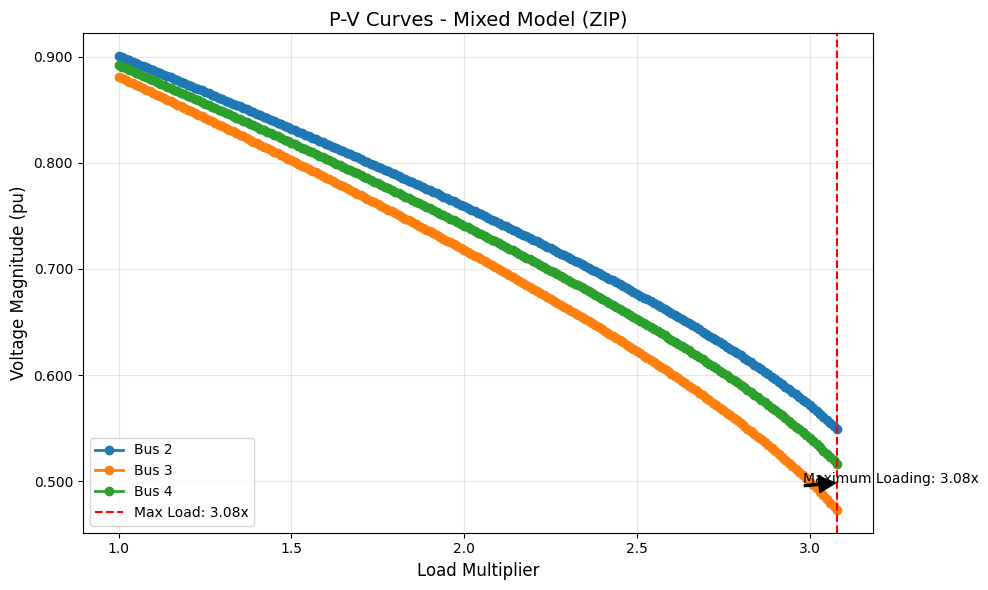

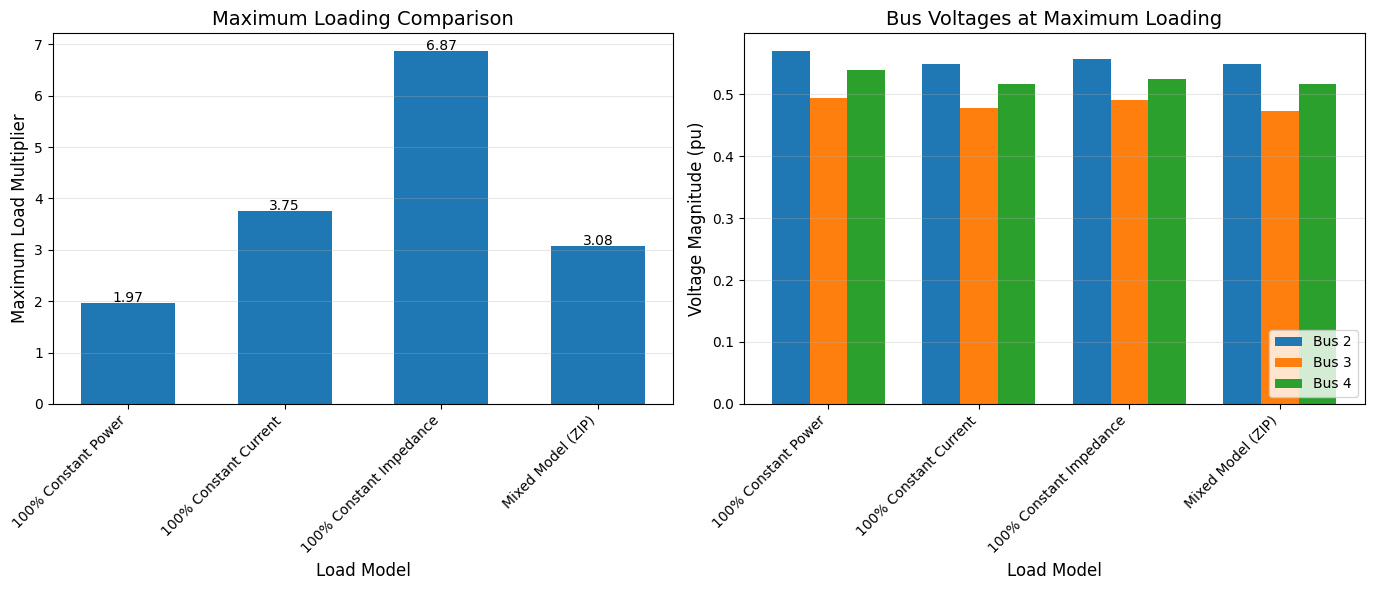


=== Maximum Loading Summary ===
Load Model                Max Load Factor
----------------------------------------
100% Constant Power       1.970          
100% Constant Current     3.750          
100% Constant Impedance   6.870          
Mixed Model (ZIP)         3.080          


In [20]:


results = run_pv_curve_analysis()

# Print maximum loading for each scenario
print("\n=== Maximum Loading Summary ===")
print("{:<25} {:<15}".format("Load Model", "Max Load Factor"))
print("-" * 40)

for name, res in results.items():
    last_idx = res['converged'].index(False) - 1 if False in res['converged'] else -1
    max_load = res['load_multipliers'][last_idx]
    print(f"{name:<25} {max_load:<15.3f}")